SETUP

In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras
import qkeras
from qkeras import *

In [2]:
X = np.load("/Users/jackcleeve/Desktop/Research/Karagiorgi-Lab/current_project/bnb_WithWire_00_pureNu_batch_00_10X4.npy")

In [3]:
X.shape

(2560, 864, 64, 1)

In [4]:
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)

In [5]:
#model = keras.models.load_model("noQDB_seq", custom_objects=co)
teacher = keras.models.load_model('/Users/jackcleeve/Desktop/Research/Karagiorgi-Lab/current_project/Seokju_Models/teacher_10X4')
student_test = qkeras.utils.load_qmodel('/Users/jackcleeve/Desktop/Research/Karagiorgi-Lab/current_project/Seokju_Models/Cicada2_tiles10X4_full17')

In [6]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 teacher_inputs_ (InputLaye  [(None, 864, 64, 1)]      0         
 r)                                                              
                                                                 
 teacher_reshape (Reshape)   (None, 864, 64, 1)        0         
                                                                 
 teacher_conv2d_1 (Conv2D)   (None, 864, 64, 20)       200       
                                                                 
 teacher_relu_1 (Activation  (None, 864, 64, 20)       0         
 )                                                               
                                                                 
 teacher_pool_1 (AveragePoo  (None, 432, 32, 20)       0         
 ling2D)                                                         
                                                           

In [7]:
student_test.summary()

Model: "cicada-v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs_ (InputLayer)        [(None, 55296)]           0         
                                                                 
 reshape (Reshape)           (None, 864, 64, 1)        0         
                                                                 
 conv (QConv2D)              (None, 432, 32, 4)        16        
                                                                 
 relu0 (QActivation)         (None, 432, 32, 4)        0         
                                                                 
 flatten (Flatten)           (None, 55296)             0         
                                                                 
 dense1 (QDense)             (None, 16)                884736    
                                                                 
 relu1 (QActivation)         (None, 16)                0 

In [8]:
import hls4ml
import QDenseBatchnorm


In [9]:
config = hls4ml.utils.config_from_keras_model(student_test, backend='Vitis', 
                                              default_precision='fixed<32,16>',
                                              granularity='name')

Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 55296]], output shape: [None, 55296]
Layer name: reshape, layer type: Reshape, input shapes: [[None, 55296]], output shape: [None, 864, 64, 1]
Layer name: conv, layer type: QConv2D, input shapes: [[None, 864, 64, 1]], output shape: [None, 432, 32, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 432, 32, 4]], output shape: [None, 432, 32, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 432, 32, 4]], output shape: [None, 55296]
Layer name: dense1, layer type: QDense, input shapes: [[None, 55296]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]


/Users/jackcleeve/anaconda3/envs/fastml310/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True

In [11]:
config

{'Model': {'Precision': 'fixed<32,16>',
  'ReuseFactor': 1,
  'Strategy': 'Latency',
  'BramFactor': 1000000000,
  'TraceOutput': False},
 'LayerName': {'inputs_': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>'}},
  'reshape': {'Trace': True, 'Precision': {'result': 'fixed<32,16>'}},
  'conv': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>',
    'weight': 'fixed<16,5>',
    'bias': 'fixed<32,16>',
    'accum': 'fixed<32,16>'},
   'ReuseFactor': 1,
   'ParallelizationFactor': 1,
   'ConvImplementation': 'LineBuffer'},
  'conv_linear': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>', 'table': 'fixed<18,8>'},
   'ReuseFactor': 1,
   'TableSize': 1024},
  'relu0': {'Trace': True,
   'Precision': {'result': 'ufixed<10,4,RND_CONV,SAT>',
    'table': 'fixed<18,8>'},
   'ReuseFactor': 1,
   'TableSize': 1024},
  'flatten': {'Trace': True, 'Precision': {'result': 'fixed<32,16>'}},
  'dense1': {'Trace': True,
   'Precision': {'result': 'fixed<32,16>',
    'weight':

In [12]:
hls_model = hls4ml.converters.convert_from_keras_model(student_test,
                                                       hls_config=config,
                                                       io_type='io_parallel',
                                                       output_dir=f'cicada2_10x4_hls4mlproj')

Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 55296]], output shape: [None, 55296]
Layer name: reshape, layer type: Reshape, input shapes: [[None, 55296]], output shape: [None, 864, 64, 1]
Layer name: conv, layer type: QConv2D, input shapes: [[None, 864, 64, 1]], output shape: [None, 432, 32, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 432, 32, 4]], output shape: [None, 432, 32, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 432, 32, 4]], output shape: [None, 55296]
Layer name: dense1, layer type: QDense, input shapes: [[None, 55296]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model


In [13]:
X_flat = X.reshape((2560,-1))

In [14]:
X_flat.shape

(2560, 55296)

In [15]:
def loss(y_true, y_pred, choice):
    if choice == 'mse':
        loss = np.mean((y_true - y_pred)**2, axis = (1,2,3))
        return loss

ntimeticks = 6400
nwire = 3456
f_downsample = 10
h_split = 10
v_split = 4
nbatch = 32

strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

adccutoff = 10.*f_downsample/10.
adcsaturation = 100.*f_downsample/10.

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


COMPILING AND PREDICTING

In [16]:
#Y = student_test.predict(X_flat)

X_predict_teacher = teacher.predict(X)
X_loss_teacher = loss(X, X_predict_teacher, 'mse')
X_student = X.reshape((-1,nwire*ntimeticks//f_downsample//v_split//h_split,1))
Y = student_test.predict(X_student).reshape(len(X_loss_teacher))


80/80 [==============================] - 1s 10ms/step


In [17]:
hls_model.compile()

Writing HLS project


/Users/jackcleeve/anaconda3/envs/fastml310/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Done


In [18]:
fake_hls4ml_pred, hls4ml_trace = hls_model.trace(X)

Recompiling myproject with tracing
Writing HLS project
Done


In [19]:
#Y_hls = hls_model.predict(X_flat)
y_predict_hls4ml_q = hls_model.predict(np.ascontiguousarray(X.reshape((-1,nwire*ntimeticks//f_downsample//v_split//h_split,1)))).reshape(len(X_loss_teacher))


RESULTS

In [20]:
for j in Y:
    print(j)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0351562
1.1875
63.996094
5.1914062
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9609375
4.6171875
63.996094
63.996094
63.996094
34.546875
0.0
0.0
0.0
0.0
0.0
13.425781
8.5078125
11.203125
2.6210938
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

In [21]:
for i in y_predict_hls4ml_q:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.01171875
1.16015625
41.21875
5.11328125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.9453125
4.52734375
63.99609375
49.87890625
63.99609375
33.71875
0.0
0.0
0.0
0.0
0.0
25.63671875
8.35546875
11.19921875
2.5703125
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0

In [22]:
import matplotlib.pyplot as plt

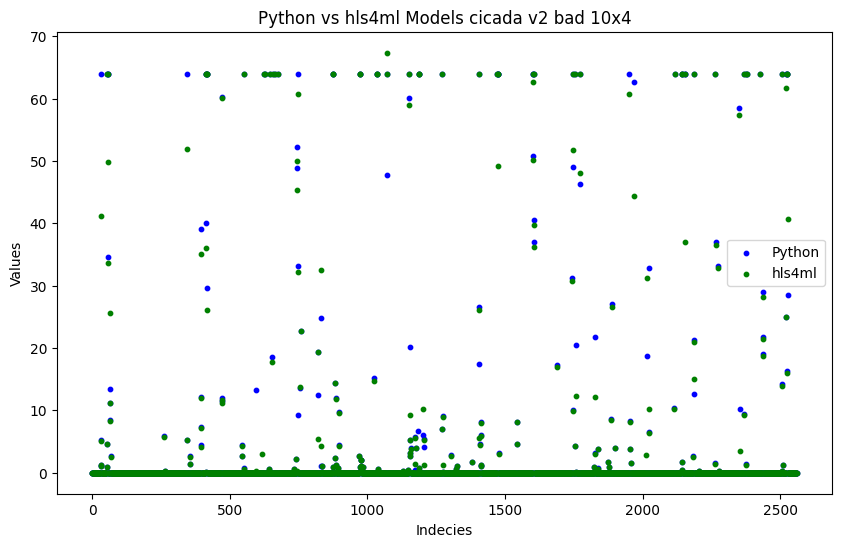

In [24]:
differences = [pred1 != pred2 for pred1, pred2 in zip(Y, y_predict_hls4ml_q)]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(Y)), Y, color='blue', s=10, label='Python')
plt.scatter(range(len(y_predict_hls4ml_q)), y_predict_hls4ml_q, color='green', s=10, label='hls4ml')

plt.xlabel('Indecies')
plt.ylabel('Values')
plt.title('Python vs hls4ml Models cicada v2 bad 10x4')
plt.legend()
plt.show()
# Labels and title

In [25]:
off_list = np.argwhere(~np.isclose(Y, y_predict_hls4ml_q))

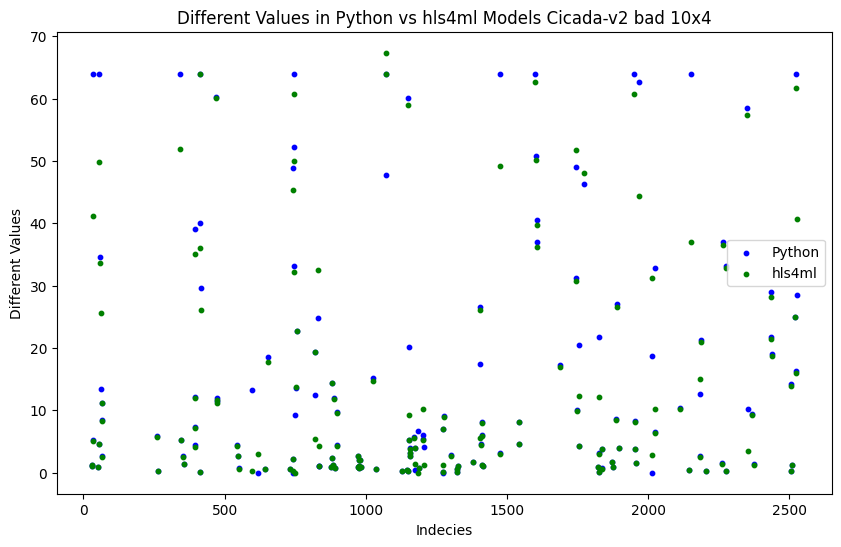

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(off_list, Y[off_list], color='blue', s=10, label='Python')
plt.scatter(off_list, y_predict_hls4ml_q[off_list], color='green', s=10, label='hls4ml')

plt.xlabel('Indecies')
plt.ylabel('Different Values')
plt.title('Different Values in Python vs hls4ml Models Cicada-v2 bad 10x4')
plt.legend()
plt.show()

In [27]:
non_zero_list = np.argwhere(~np.isclose(0.0, y_predict_hls4ml_q))

In [28]:
len(off_list)

163

In [29]:
len(non_zero_list)

210

In [30]:
off_list_indexes = []
for k in off_list:
    off_list_indexes.append(k[0])

for ind in off_list_indexes:
    print("Y: ")
    print(Y[ind])
    print("hls pred: ")
    print(y_predict_hls4ml_q[ind])

Y: 
1.0351562
hls pred: 
1.01171875
Y: 
1.1875
hls pred: 
1.16015625
Y: 
63.996094
hls pred: 
41.21875
Y: 
5.1914062
hls pred: 
5.11328125
Y: 
0.9609375
hls pred: 
0.9453125
Y: 
4.6171875
hls pred: 
4.52734375
Y: 
63.996094
hls pred: 
49.87890625
Y: 
34.546875
hls pred: 
33.71875
Y: 
13.425781
hls pred: 
25.63671875
Y: 
8.5078125
hls pred: 
8.35546875
Y: 
11.203125
hls pred: 
11.19921875
Y: 
2.6210938
hls pred: 
2.5703125
Y: 
5.8359375
hls pred: 
5.7265625
Y: 
0.30078125
hls pred: 
0.296875
Y: 
63.996094
hls pred: 
51.99609375
Y: 
5.2265625
hls pred: 
5.2421875
Y: 
2.6054688
hls pred: 
2.5625
Y: 
1.4140625
hls pred: 
1.37890625
Y: 
7.2734375
hls pred: 
7.140625
Y: 
39.164062
hls pred: 
35.09375
Y: 
4.4023438
hls pred: 
4.16015625
Y: 
12.21875
hls pred: 
11.99609375
Y: 
63.996094
hls pred: 
63.9921875
Y: 
40.054688
hls pred: 
36.08984375
Y: 
0.19140625
hls pred: 
0.171875
Y: 
29.660156
hls pred: 
26.14453125
Y: 
60.296875
hls pred: 
60.09375
Y: 
11.957031
hls pred: 
11.7421875
Y: 
11.48

In [31]:
diff_sum=0
for ind in off_list_indexes:
    diff = abs(Y[ind] - y_predict_hls4ml_q[ind])
    diff_sum=diff_sum+diff
diff_avg = diff_sum/len(off_list)
print(diff_avg)

2.1558425996932513


In [32]:
diff_pct = []
for ind in off_list_indexes:
    diff = abs(Y[ind] - y_predict_hls4ml_q[ind])
    if Y[ind]==0:
        temp_diff_pct = diff
    else:
        temp_diff_pct = diff/Y[ind]
    diff_pct.append(temp_diff_pct)

In [33]:
diff_pct_avg = sum(diff_pct)/len(diff_pct)
print(diff_pct_avg)

0.17528542979562062


In [38]:
np.allclose(Y, y_predict_hls4ml_q, atol=27)

True

WEIGHTS

Interpreting Model
Topology:
Layer name: inputs_, layer type: InputLayer, input shapes: [[None, 55296]], output shape: [None, 55296]
Layer name: reshape, layer type: Reshape, input shapes: [[None, 55296]], output shape: [None, 864, 64, 1]
Layer name: conv, layer type: QConv2D, input shapes: [[None, 864, 64, 1]], output shape: [None, 432, 32, 4]
Layer name: relu0, layer type: Activation, input shapes: [[None, 432, 32, 4]], output shape: [None, 432, 32, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 432, 32, 4]], output shape: [None, 55296]
Layer name: dense1, layer type: QDense, input shapes: [[None, 55296]], output shape: [None, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: dense2, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 1]
Layer name: outputs, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Creating HLS model
Profiling weights (before optimizati

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

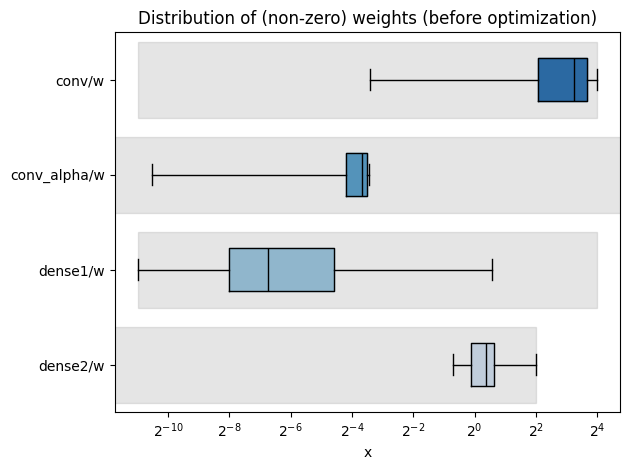

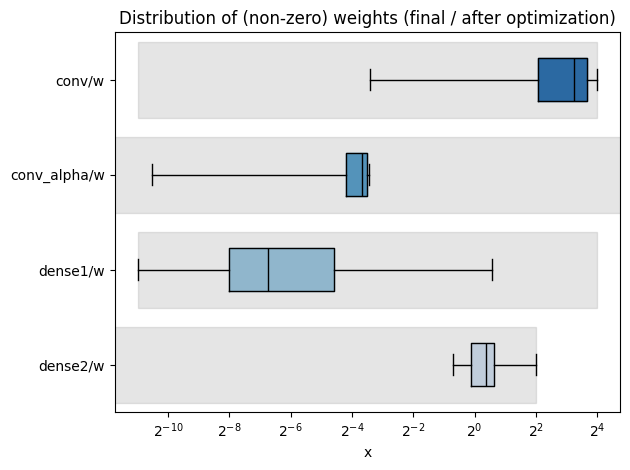

In [39]:
hls4ml.model.profiling.numerical(model=student_test, hls_model=hls_model)

In [40]:
print(hls4ml_trace)

{'conv': array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
      

In [42]:
layers = student_test.layers
conv_weights = student_test.layers[2].get_weights()
dense_weights = student_test.layers[5].get_weights()
qdensebatchnorm_weights = student_test.layers[7].get_weights()
print(layers)
print(conv_weights)
print(dense_weights)
print(qdensebatchnorm_weights)

[<keras.src.engine.input_layer.InputLayer object at 0x17e08dde0>, <keras.src.layers.reshaping.reshape.Reshape object at 0x31fbda7a0>, <qkeras.qconvolutional.QConv2D object at 0x31fbdbd90>, <qkeras.qlayers.QActivation object at 0x31fc112a0>, <keras.src.layers.reshaping.flatten.Flatten object at 0x31fc11d20>, <qkeras.qlayers.QDense object at 0x31fc11a80>, <qkeras.qlayers.QActivation object at 0x31fbb6e90>, <qkeras.qlayers.QDense object at 0x31fbb45e0>, <qkeras.qlayers.QActivation object at 0x17e63d180>]
[array([[[[ 0.01094244, -1.1627184 , -1.37065   , -0.00857576]],

        [[-0.00495676, -0.00768378, -0.43709928, -1.0584035 ]]],


       [[[ 0.00636385, -0.08863028, -0.83232003, -1.4625554 ]],

        [[ 0.00721341, -0.76558834, -0.7809451 , -0.12478598]]]],
      dtype=float32)]
[array([[-0.22550976, -0.0867291 , -0.23133016, ..., -0.07548987,
         0.09557293, -0.06605119],
       [ 0.00085287,  0.00206516,  0.00725163, ...,  0.00387107,
         0.00346039, -0.00190284],
      

In [43]:
#print(min(conv_weights))
conv_weights_list = []
for i in conv_weights[0][0][0][0]:
    conv_weights_list.append(i)
for j in conv_weights[0][1][0][0]:
    conv_weights_list.append(j)
print(min(conv_weights_list), max(conv_weights_list))

-1.4625554 0.010942439


In [44]:
print(min(dense_weights[0]), max(dense_weights[0]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [30]:
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

KeyError: 'XILINX_VIVADO'

In [30]:
hls4ml build -p complex_hls4mlproj

SyntaxError: invalid syntax (3971047448.py, line 1)

In [29]:
hls_model.build(csim=False, synth=True, vsynth=True)

Project myproject_prj does not exist. Rerun "hls4ml build -p complex_hls4mlproj".


sh: vivado_hls: command not found


In [ ]:
from pathlib import Path
import pprint

def getReports(indir):
    data_ = {}

    report_vsynth = Path('{}/vivado_synth.rpt'.format(indir))
    report_csynth = Path('{}/myproject_prj/solution1/syn/report/myproject_csynth.rpt'.format(indir))

    if report_vsynth.is_file() and report_csynth.is_file():
        print('Found valid vsynth and synth in {}! Fetching numbers'.format(indir))

        # Get the resources from the logic synthesis report
        with report_vsynth.open() as report:
            lines = np.array(report.readlines())
            data_['lut'] = int(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[2])
            data_['ff'] = int(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[2])
            data_['bram'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[2])
            data_['dsp'] = int(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[2])
            data_['lut_rel'] = float(lines[np.array(['CLB LUTs*' in line for line in lines])][0].split('|')[5])
            data_['ff_rel'] = float(lines[np.array(['CLB Registers' in line for line in lines])][0].split('|')[5])
            data_['bram_rel'] = float(lines[np.array(['Block RAM Tile' in line for line in lines])][0].split('|')[5])
            data_['dsp_rel'] = float(lines[np.array(['DSPs' in line for line in lines])][0].split('|')[5])

        with report_csynth.open() as report:
            lines = np.array(report.readlines())
            lat_line = lines[np.argwhere(np.array(['Latency (cycles)' in line for line in lines])).flatten()[0] + 3]
            data_['latency_clks'] = int(lat_line.split('|')[2])
            data_['latency_mus'] = float(lat_line.split('|')[2]) * 5.0 / 1000.0
            data_['latency_ii'] = int(lat_line.split('|')[6])

    return data_

In [ ]:
data_quantized_pruned = getReports('complex_hls4mlproj')

print("\n Resource usage and latency: ")
pprint.pprint(data_quantized_pruned)